<a href="https://colab.research.google.com/github/Atharvamu/aipal-industrial-dqn/blob/main/dqn_sb3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN and Double DQN

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines.readthedocs.io/en/master/


Double Q-Learning: https://paperswithcode.com/method/double-q-learning



## Installation

We will install master version of SB3.

In [33]:
!pip install git+https://github.com/Atharvamu/aipal-industrial-dqn.git

  Cloning https://github.com/Atharvamu/aipal-industrial-dqn.git to /tmp/pip-req-build-56un9g55
  Running command git clone --filter=blob:none --quiet https://github.com/Atharvamu/aipal-industrial-dqn.git /tmp/pip-req-build-56un9g55
  Resolved https://github.com/Atharvamu/aipal-industrial-dqn.git to commit 9a293d32c06b0297a7018d1df8b30df26c34e656
  Preparing metadata (setup.py) ... done


Import DQN and evaluation helper

## 🏭 Industrial Automation Environment

In this environment, the agent is responsible for maintaining a simulated industrial production system. The goal is to maximize product quality and machine health over time by tuning control parameters and scheduling maintenance effectively.








 Observation Space
Type: Box(5,)
Each observation is a vector of 5 continuous values:

| Num | Observation            | Min | Max |
| --- | ---------------------- | --- | --- |
| 0   | Machine Health         | 0.0 | 1.0 |
| 1   | Product Quality        | 0.0 | 1.0 |
| 2   | Time Since Maintenance | 0.0 | 1.0 |
| 3   | Control Parameter 1    | 0.0 | 1.0 |
| 4   | Control Parameter 2    | 0.0 | 1.0 |

🎮 Action Space
Type: Discrete(6)

| Num | Action                  |
| --- | ----------------------- |
| 0   | No Operation            |
| 1   | Increase Control Param1 |
| 2   | Decrease Control Param1 |
| 3   | Increase Control Param2 |
| 4   | Decrease Control Param2 |
| 5   | Perform Maintenance     |


🎯 Reward
Reward is designed to encourage:


*   High product quality
*   Stable machine health
*   Well-timed maintenance scheduling


Bonuses are awarded for:


*   Timely and effective maintenance



Penalties are applied for:


*   Maintenance that is too early or too late
*   Low product quality or machine failure



🔒 Note: Rewards are clipped to the range [-1.0, 1.0] to improve training stability.

📈 Optimal Control Shaping:

Product quality is also influenced by how close the control parameters are to ideal values.This simulates a realistic manufacturing setting where certain parameter combinations yield optimal performance. A Gaussian function boosts quality when:

*   Param1 is near 0.7
*   Param2 is near 0.3


🚦 Starting State


*   Machine Health:
Drawn from a normal distribution ~𝓝(0.9, 0.05), then clipped to the range [0.7, 1.0].
*   Product Quality:
Sampled uniformly from the range [0.4, 0.7].

*   Time Since Maintenance:

      70% chance of starting at 0.0

      30% chance of a value sampled uniformly from [0.1, 0.3]
*   Control Parameters 1 & 2:
Sampled uniformly from the range [0.4, 0.6]





⛔ Episode Termination(The episode terminates when any of the following conditions are met):


*   Machine Health drops to 0.0 (system failure)
*   Product Quality falls below 0.4 (product defect)

*   Maximum of 300 steps is reached (timeout)













In [34]:

from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.dqn.policies import DQNPolicy
import gymnasium as gym
from gymnasium import spaces
import torch as th
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import os

##PART 1 - DQN

In [35]:
# Initialize and validate env
env = IndustrialAutomationEnv()
check_env(env)

In [36]:
# Train DQN
model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=1e-3,
    buffer_size=10000,
    learning_starts=1000,
    batch_size=32,
    tau=0.005, # Soft update parameter; otherwise results are worse
    gamma=0.99,
    train_freq=4,
    #target_update_interval=10,
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    tensorboard_log="./dqn_tensorboard/"
)

model.learn(total_timesteps=100_000)
model.save("dqn_industrial_env")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./dqn_tensorboard/DQN_3
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | 117      |
|    exploration_rate | 0.882    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2423     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1200     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00114  |
|    n_updates        | 49       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | 118      |
|    exploration_rate | 0.765    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1039     |
|    time_elapsed     | 2        |
|    total_timesteps  | 2400   

Episode 1 completed


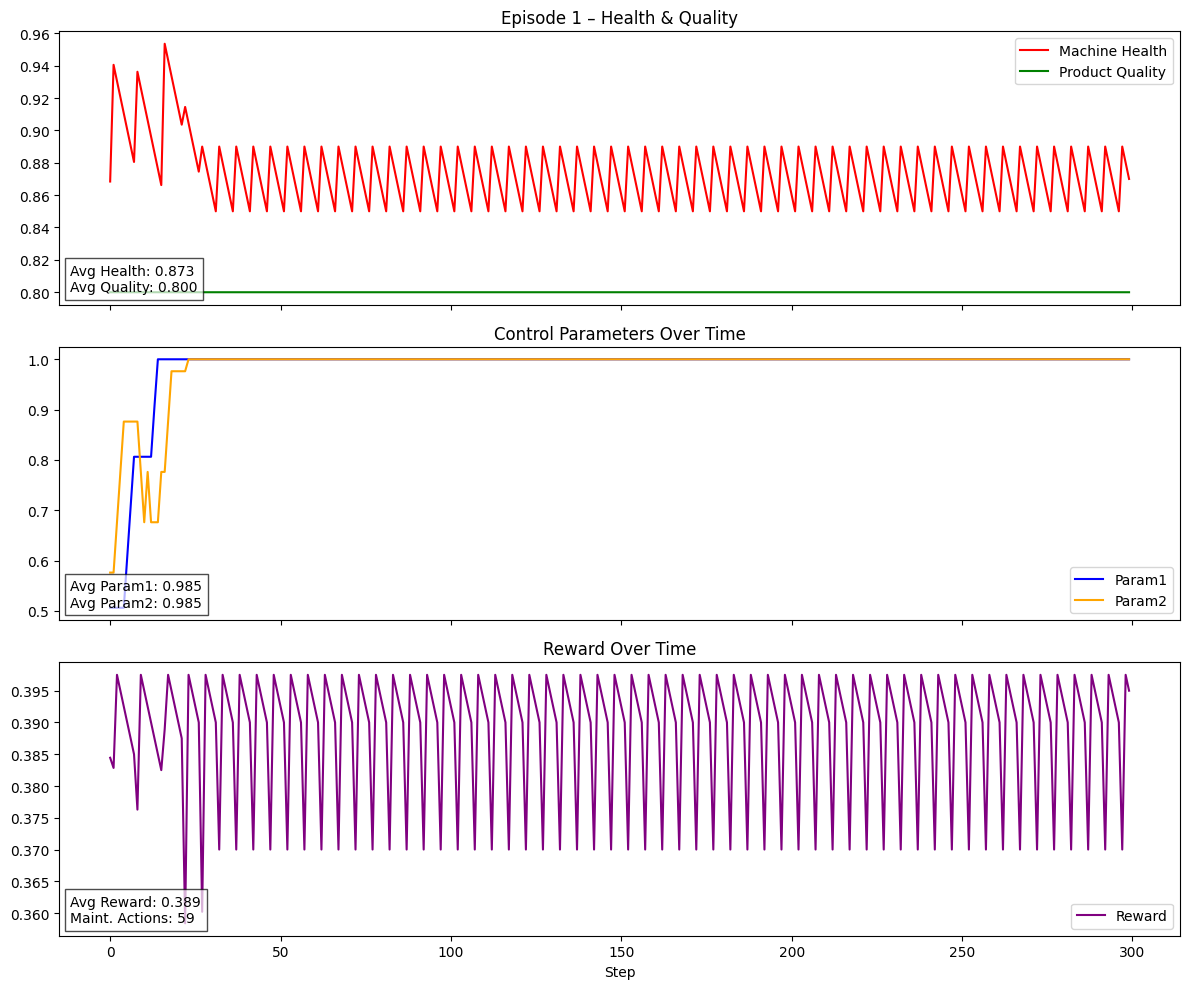

Episode 2 completed


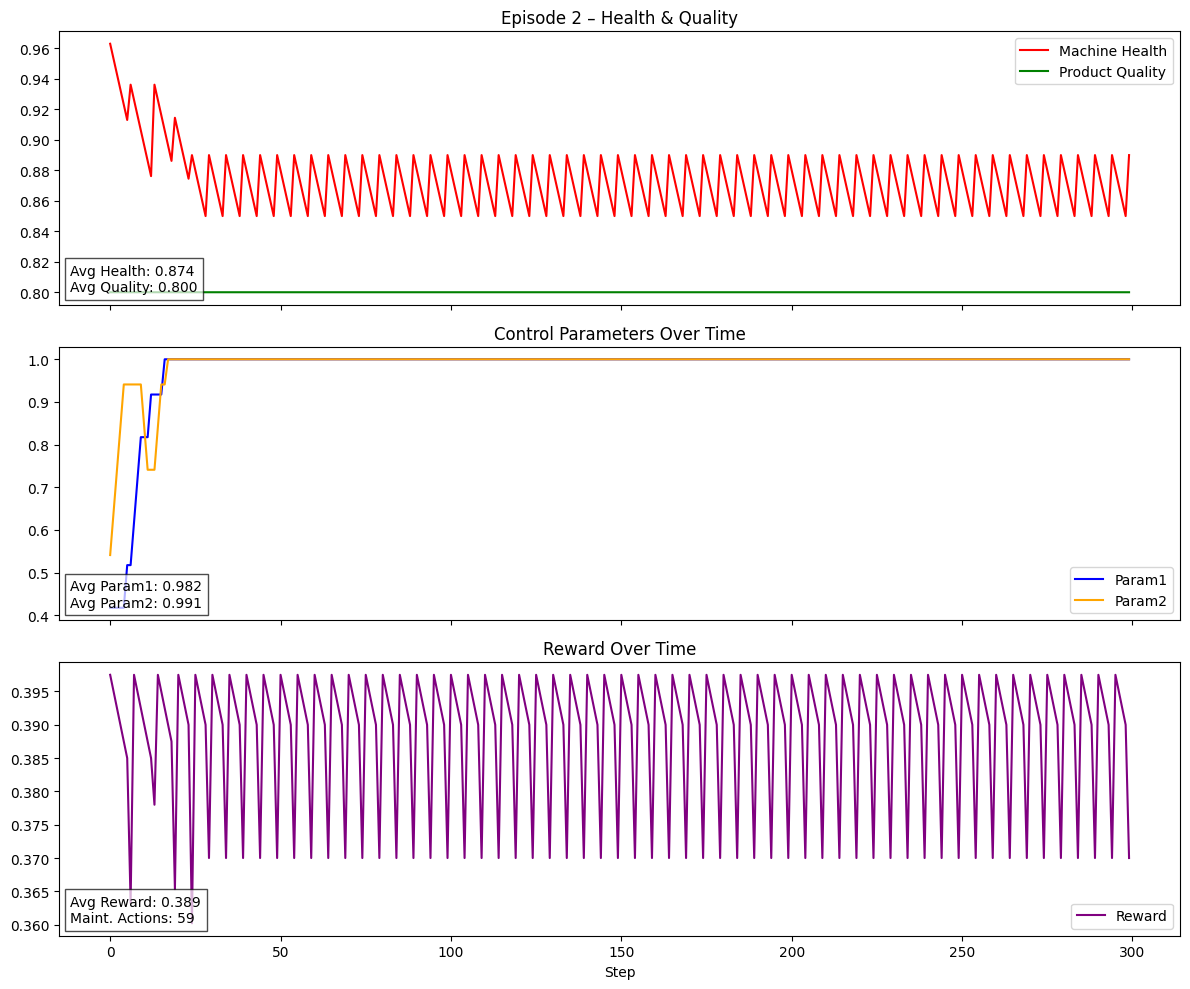

Episode 3 completed


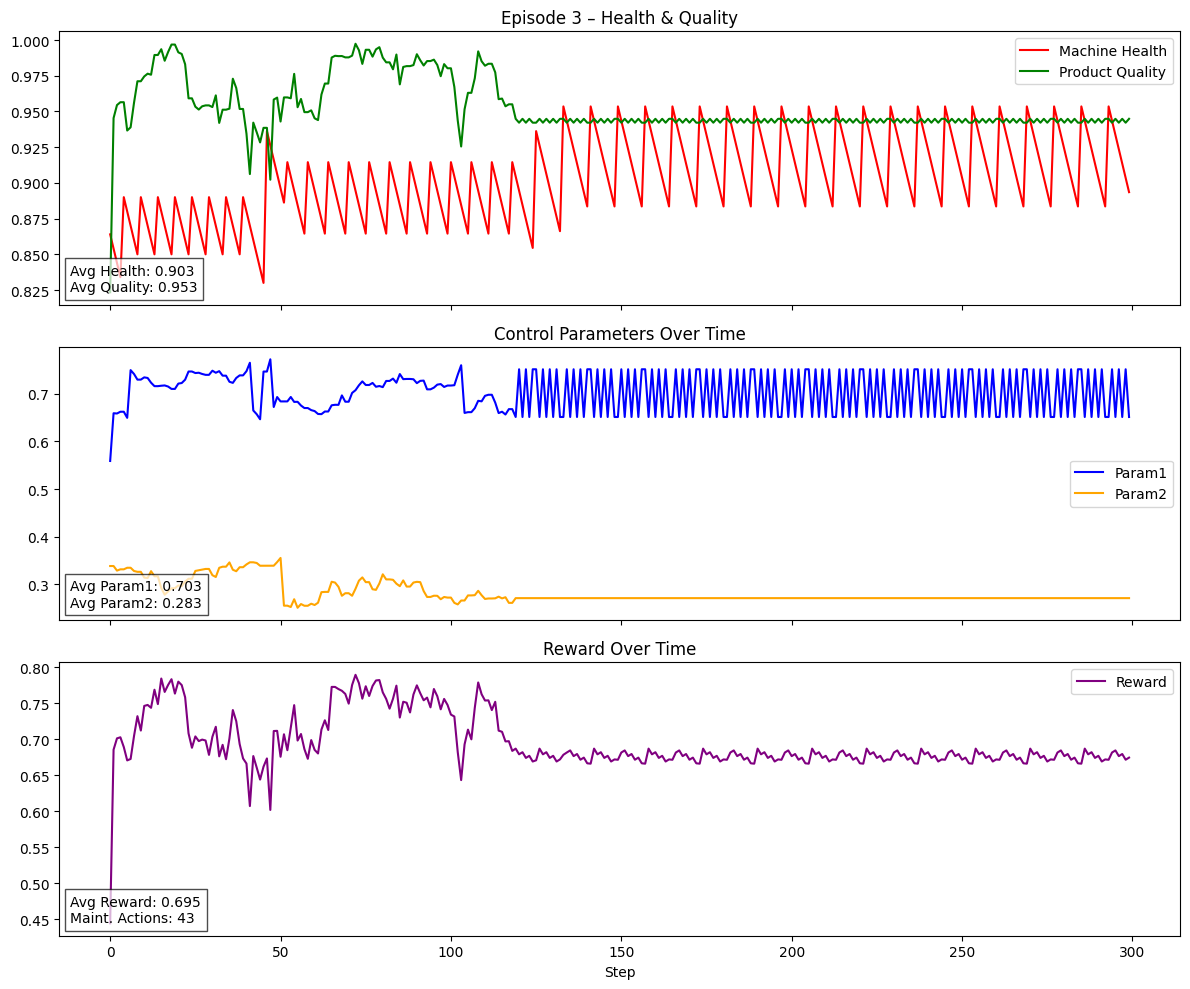

Episode 4 completed


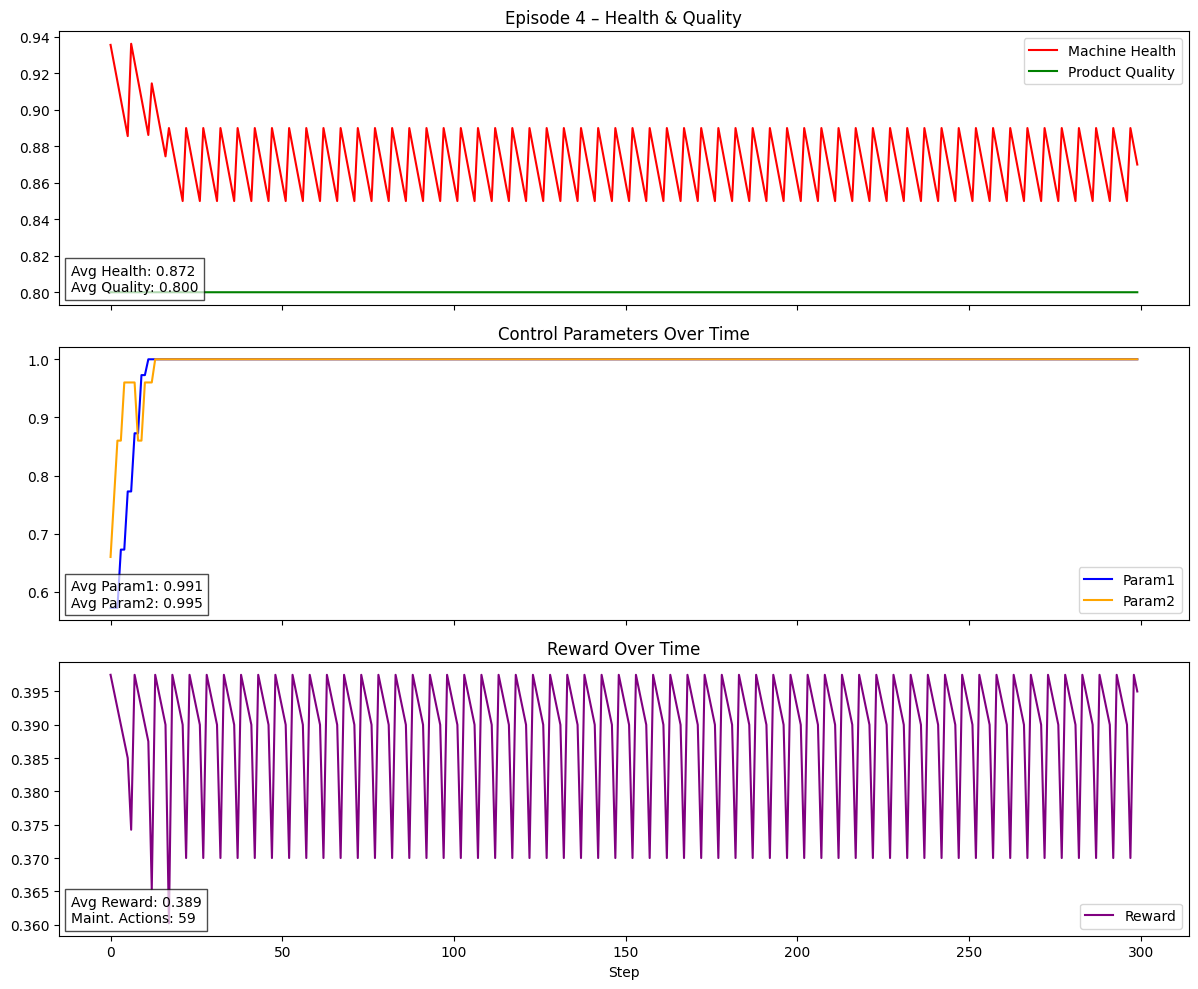

Episode 5 completed


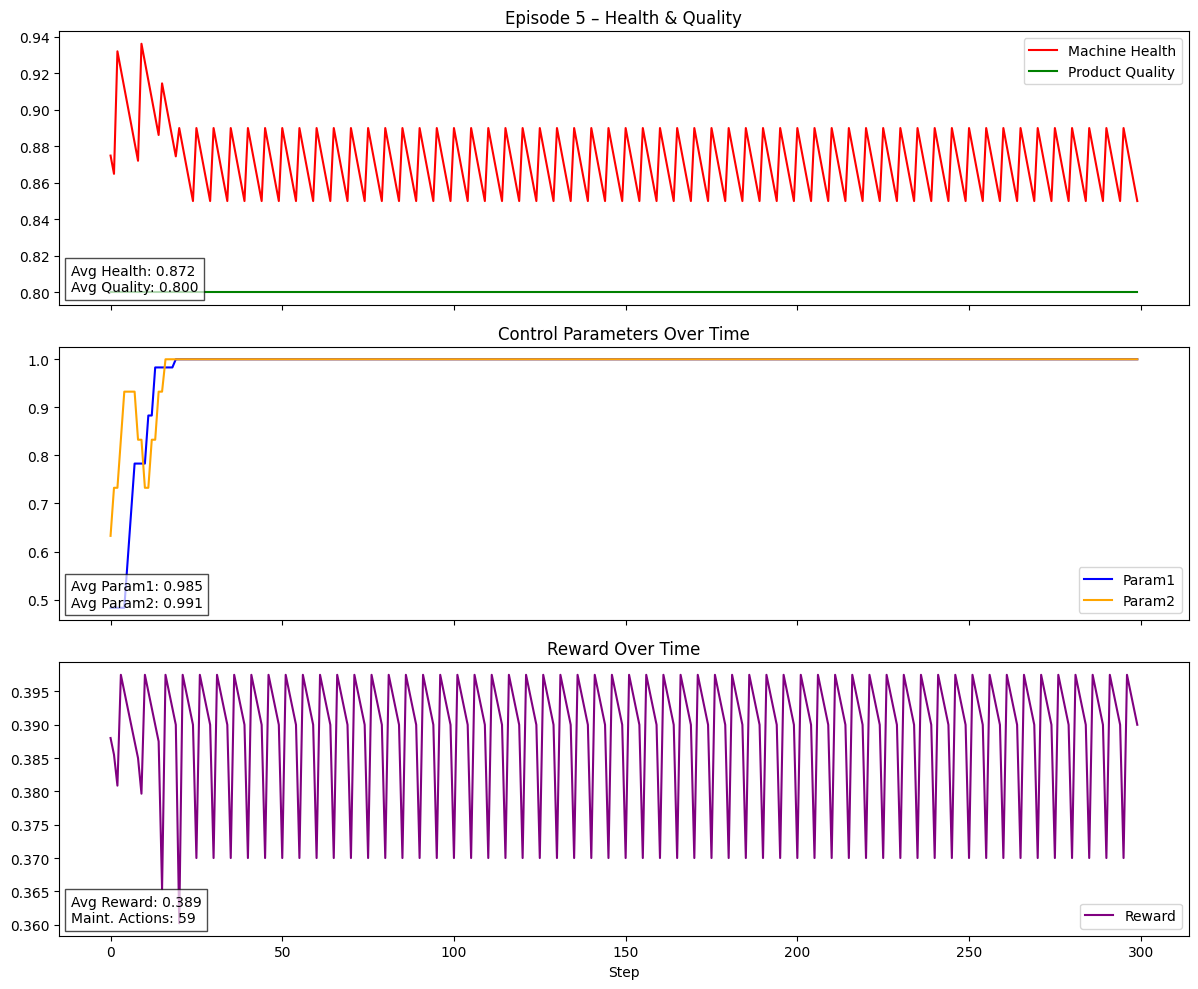

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics, title, maintenance_count=None):
    steps = range(len(metrics['rewards']))

    # Calculate averages
    avg_health = np.mean(metrics['healths'])
    avg_quality = np.mean(metrics['qualities'])
    avg_param1 = np.mean(metrics['param1s'])
    avg_param2 = np.mean(metrics['param2s'])
    avg_reward = np.mean(metrics['rewards'])

    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Plot 1: Health & Quality
    axs[0].plot(steps, metrics['healths'], label="Machine Health", color='red')
    axs[0].plot(steps, metrics['qualities'], label="Product Quality", color='green')
    axs[0].set_title(f"{title} – Health & Quality")
    axs[0].legend()
    axs[0].text(0.01, 0.05,
        f"Avg Health: {avg_health:.3f}\nAvg Quality: {avg_quality:.3f}",
        transform=axs[0].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    # Plot 2: Control Parameters
    axs[1].plot(steps, metrics['param1s'], label="Param1", color='blue')
    axs[1].plot(steps, metrics['param2s'], label="Param2", color='orange')
    axs[1].set_title("Control Parameters Over Time")
    axs[1].legend()
    axs[1].text(0.01, 0.05,
        f"Avg Param1: {avg_param1:.3f}\nAvg Param2: {avg_param2:.3f}",
        transform=axs[1].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    # Plot 3: Reward
    axs[2].plot(steps, metrics['rewards'], label="Reward", color='purple')
    axs[2].set_title("Reward Over Time")
    axs[2].legend()
    reward_text = f"Avg Reward: {avg_reward:.3f}"
    if maintenance_count is not None:
        reward_text += f"\nMaint. Actions: {maintenance_count}"
    axs[2].text(0.01, 0.05, reward_text,
        transform=axs[2].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    plt.xlabel("Step")
    plt.tight_layout()
    plt.show()


# Evaluate 5 episodes
for ep in range(5):
    env = IndustrialAutomationEnv()
    obs, _ = env.reset()
    done = False
    maintenance_count = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        if action == 5:
            maintenance_count += 1
        done = terminated or truncated

    print(f"Episode {ep + 1} completed")
    plot_metrics(env.metrics, f"Episode {ep + 1}", maintenance_count=maintenance_count)


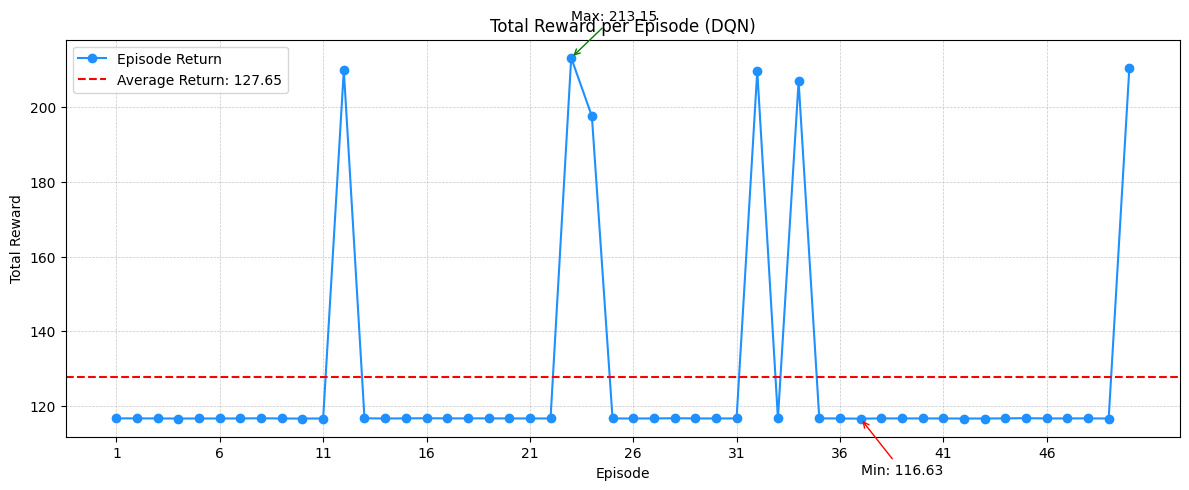

In [38]:
episode_returns = []
for _ in range(50):
    env = IndustrialAutomationEnv()
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        done = terminated or truncated

    episode_returns.append(total_reward)

# Compute average
avg_return = np.mean(episode_returns)

# Get min/max indexes
min_idx = np.argmin(episode_returns)
max_idx = np.argmax(episode_returns)

# Plot line graph with average + min/max highlights
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(episode_returns) + 1), episode_returns, marker='o', linestyle='-', color='dodgerblue', label='Episode Return')
plt.axhline(avg_return, color='red', linestyle='--', label=f'Average Return: {avg_return:.2f}')

# Annotate min and max
plt.annotate(f"Min: {episode_returns[min_idx]:.2f}",
             xy=(min_idx + 1, episode_returns[min_idx]),
             xytext=(min_idx + 1, episode_returns[min_idx] - 15),
             arrowprops=dict(arrowstyle="->", color='red'))

plt.annotate(f"Max: {episode_returns[max_idx]:.2f}",
             xy=(max_idx + 1, episode_returns[max_idx]),
             xytext=(max_idx + 1, episode_returns[max_idx] + 10),
             arrowprops=dict(arrowstyle="->", color='green'))

plt.title("Total Reward per Episode (DQN)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.xticks(np.arange(1, len(episode_returns) + 1, 5))
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

## 🔍 Interpreting DQN Performance: Are We Missing Something?

In the previous plot, we saw that the DQN agent achieves a **fairly consistent and decent total reward** across episodes.

However, reward alone doesn't tell the whole story.

Let’s now investigate **how often the agent performed maintenance** during those episodes.

Excessive maintenance may signal that the agent found a **safe but expensive strategy**, rather than optimizing in a smarter way.


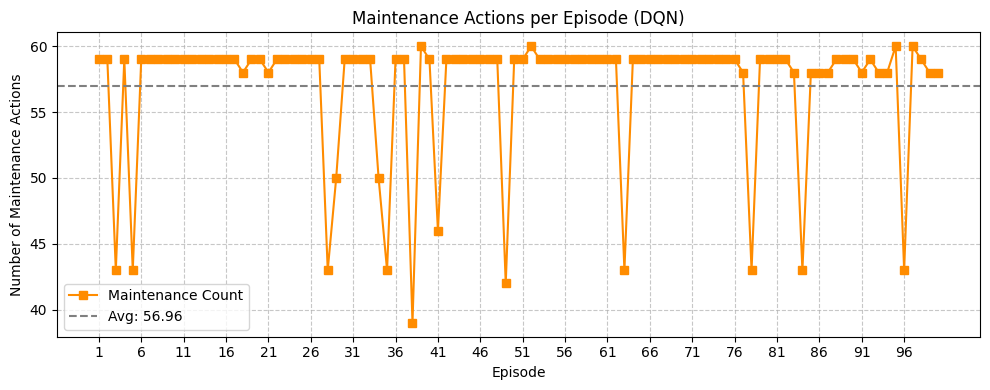

In [39]:
maintenance_counts = []

for _ in range(100):
    env = IndustrialAutomationEnv()
    obs, _ = env.reset()
    done = False
    maint_count = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        if action == 5:
            maint_count += 1
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    maintenance_counts.append(maint_count)

plt.figure(figsize=(10, 4))
plt.plot(range(1, len(maintenance_counts) + 1), maintenance_counts, marker='s', color='darkorange', label="Maintenance Count")
plt.axhline(np.mean(maintenance_counts), color='gray', linestyle='--', label=f'Avg: {np.mean(maintenance_counts):.2f}')
plt.title("Maintenance Actions per Episode (DQN)")
plt.xlabel("Episode")
plt.ylabel("Number of Maintenance Actions")
plt.xticks(np.arange(1, len(maintenance_counts)+1, 5))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


## 🧭 Why Try Double DQN (DDQN)?

While DQN learned to preserve machine health and product quality, it may have **over-relied on maintenance** once it found a "safe" strategy.

This often happens because DQN tends to **overestimate action values**, leading to biased policy learning.

In the next section, we'll switch to **Double DQN (DDQN)**, which uses two Q-networks to decouple action selection from target estimation — reducing this overestimation bias and promoting more balanced behavior.


## Exercise (30 minutes): Double DQN

In DQN, the same network is responsible for selecting and estimating the best next action (in the TD-target) and that may lead to over-estimation (the action which q-value is over-estimated will be chosen more often and this slow down training). Over time, this bias slows down learning and may lock the agent into repetitive or overly cautious behavior (e.g., excessive maintenance).

To reduce over-estimation, double q-learning (and then double DQN) was proposed. It decouples the action selection from the value estimation.This is done by using two Q-networks:

Evaluation network (with parameters θ): used to select the best next action

Target network (with parameters θ′): used to evaluate the value of that action

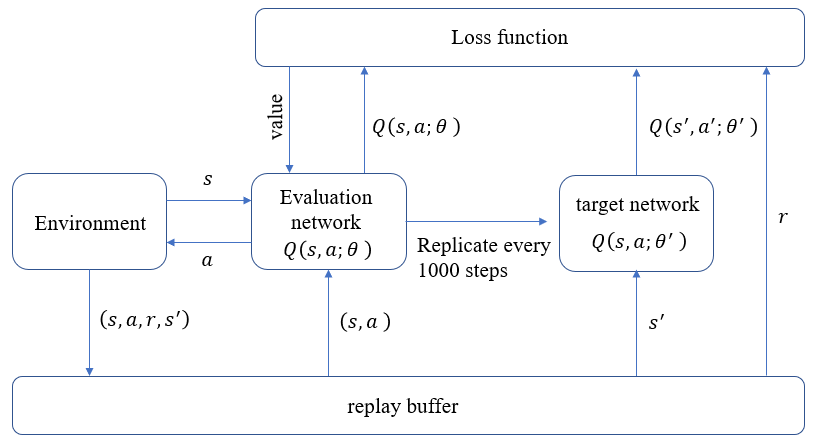

Environment generates transitions (s, a, r, s′) which go into the Replay Buffer

The Evaluation Network (Q(s, a; θ)) selects actions and is updated frequently

The Target Network (Q(s, a; θ′)) is updated less frequently (e.g., every 1000 steps) and used for stable target Q-value computation

Both networks are used in calculating the loss and improving the Evaluation Network through backpropagation

Link: https://paperswithcode.com/method/double-q-learning

Paper: https://arxiv.org/abs/1509.06461



## 1.Custom Double DQN Class

In [40]:
from torch.nn import functional as F
from stable_baselines3.dqn.dqn import DQN

class DoubleDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        self.policy.set_training_mode(True)
        self._update_learning_rate(self.policy.optimizer)
        losses = []

        for _ in range(gradient_steps):
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)

            # 🔁 DDQN Core: Action selection from q_net, value estimation from q_net_target
            with th.no_grad():
                q_values_online = self.q_net(replay_data.next_observations)
                next_actions_online = q_values_online.argmax(dim=1, keepdim=True)
                q_values_target = self.q_net_target(replay_data.next_observations)
                next_q_values = q_values_target.gather(1, next_actions_online)
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # 🔧 Compute loss
            current_q_values = self.q_net(replay_data.observations)
            current_q_values = current_q_values.gather(1, replay_data.actions.long())
            loss = F.smooth_l1_loss(current_q_values, target_q_values)

            # ⬇️ Gradient update
            self.policy.optimizer.zero_grad()
            loss.backward()
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

            losses.append(loss.item())

            # Optional logging
            if self._n_updates % 100 == 0:
                self.logger.record("train/q_max", float(current_q_values.max()))
                self.logger.record("train/q_mean", float(current_q_values.mean()))
                self.logger.record("train/loss_hist", float(loss.item()))

        self._n_updates += gradient_steps
        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))


##2. Policy & Environment Setup

In [41]:
# ✅ Policy architecture config
from torch import nn
policy_kwargs = dict(
    net_arch=[128, 128],
    activation_fn=nn.ReLU
)

# ✅ Create vectorized environment
from industrial_env import IndustrialAutomationEnv
from stable_baselines3.common.env_util import make_vec_env

env = make_vec_env(IndustrialAutomationEnv, n_envs=1)

##  3. Evaluation & Checkpoint Callbacks


In [42]:
# ✅ Define evaluation and checkpoint callbacks
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback

eval_env = IndustrialAutomationEnv()

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./best_model_ddqn/",
    log_path="./logs_ddqn/",
    eval_freq=5000,
    deterministic=True,
    render=False
)

checkpoint_callback = CheckpointCallback(
    save_freq=10000,
    save_path="./checkpoints_ddqn/",
    name_prefix="ddqn_industrial"
)


##4. Model Initialization

In [43]:
model = DoubleDQN(
    policy=DQNPolicy,
    env=env,
    learning_rate=5e-4,
    buffer_size=20000,
    learning_starts=1000,
    batch_size=64,
    gamma=0.99,
    train_freq=4,
    target_update_interval=100,
    exploration_fraction=0.2,
    exploration_final_eps=0.05,
    tensorboard_log="./sb3_tensorboard_ddqn/",
    verbose=1,
    policy_kwargs=policy_kwargs
)

Using cpu device


##5. Train & Save Model


In [44]:
# ✅ Train the Double DQN model
model.learn(
    total_timesteps=150_000,
    callback=[eval_callback, checkpoint_callback]
)

# ✅ Save the model
model.save("sb3_ddqn_industrial_improved")
print("✅ Improved DDQN training complete and model saved.")


Logging to ./sb3_tensorboard_ddqn/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | 120      |
|    exploration_rate | 0.962    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3875     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1200     |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.0193   |
|    loss_hist        | 0.0875   |
|    n_updates        | 49       |
|    q_max            | 0.0338   |
|    q_mean           | -0.00612 |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | 119      |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1797     |
|    time_elapsed     | 1        |
|    total_time

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=112.75 +/- 0.06
Episode length: 300.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 300      |
|    mean_reward      | 113      |
| rollout/            |          |
|    exploration_rate | 0.842    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.00455  |
|    n_updates        | 999      |
----------------------------------
New best mean reward!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | 118      |
|    exploration_rate | 0.81     |
| time/               |          |
|    episodes         | 20       |
|    fps              | 1148     |
|    time_elapsed     | 5        |
|    total_timesteps  | 6000     |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss      

In [45]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from industrial_env import IndustrialAutomationEnv
from stable_baselines3 import DQN

# ✅ Load Trained Agents
sb3_dqn = DQN.load("dqn_industrial_env")
sb3_ddqn = DQN.load("sb3_ddqn_industrial_improved")  # Double DQN (custom subclass of DQN)

# 🔁 Run a single episode to collect metrics
def run_test_episode(env, model):
    obs, _ = env.reset()
    done = False
    maintenance_count = 0

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env.step(action)
        if action == 5:
            maintenance_count += 1
        done = terminated or truncated

    return env.metrics, maintenance_count

# 📊 Plot metrics from a single episode
def plot_metrics(metrics, title_prefix, maintenance_count):
    steps = range(len(metrics['rewards']))
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    avg_health = np.mean(metrics['healths'])
    avg_quality = np.mean(metrics['qualities'])
    avg_reward = np.mean(metrics['rewards'])

    axs[0].plot(steps, metrics['healths'], label='Health', color='red')
    axs[0].plot(steps, metrics['qualities'], label='Quality', color='green')
    axs[0].set_title(f"{title_prefix} – Health & Quality\nAvg Health: {avg_health:.2f}, Avg Quality: {avg_quality:.2f}")
    axs[0].legend()

    axs[1].plot(steps, metrics['param1s'], label='Param1', color='blue')
    axs[1].plot(steps, metrics['param2s'], label='Param2', color='orange')
    axs[1].set_title("Control Parameters Over Time")
    axs[1].legend()

    axs[2].plot(steps, metrics['rewards'], label='Reward', color='purple')
    axs[2].set_title(f"Reward Over Time\nAvg Reward: {avg_reward:.2f}, Maintenance: {maintenance_count}")
    axs[2].legend()

    plt.xlabel("Step")
    plt.tight_layout()
    return fig

# 🚀 Compare DQN vs DDQN on N episodes
episodes = 10
agents = [
    ("SB3 DQN", sb3_dqn),
    ("SB3 Double DQN", sb3_ddqn),
]

with PdfPages("dqn_ddqn_comparison.pdf") as pdf:
    for name, model in agents:
        print(f"\n===== Testing {name} =====")
        for ep in range(episodes):
            env = IndustrialAutomationEnv()
            metrics, maint_count = run_test_episode(env, model)
            fig = plot_metrics(metrics, f"{name} – Episode {ep+1}", maint_count)
            pdf.savefig(fig)
            plt.close(fig)

print("Comparison plots saved to: dqn_ddqn_comparison.pdf")



===== Testing SB3 DQN =====

===== Testing SB3 Double DQN =====
Comparison plots saved to: dqn_ddqn_comparison.pdf


In [46]:
from google.colab import files
files.download("dqn_ddqn_comparison.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>